In [87]:
import gensim
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.tokenize import WordPunctTokenizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tqdm
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
DATA_PATH = '../data/raw/labeled_texts_fixed.csv'

In [4]:
df = pd.read_csv(DATA_PATH)

# Готовый word2vec

In [5]:
%%time
ru_emb = KeyedVectors.load_word2vec_format("../models/word2vec_embeddings/cc.ru.300.vec")

CPU times: total: 5min 45s
Wall time: 6min 19s


In [6]:
type(ru_emb.index_to_key)

list

In [7]:
ru_emb.key_to_index

{',': 0,
 '.': 1,
 'и': 2,
 'в': 3,
 '</s>': 4,
 ':': 5,
 ')': 6,
 '(': 7,
 'на': 8,
 '"': 9,
 'с': 10,
 'не': 11,
 '»': 12,
 'для': 13,
 '-': 14,
 '«': 15,
 '/': 16,
 'по': 17,
 '—': 18,
 'что': 19,
 'В': 20,
 '!': 21,
 'из': 22,
 'от': 23,
 'к': 24,
 'как': 25,
 '?': 26,
 'а': 27,
 '–': 28,
 'за': 29,
 ';': 30,
 'о': 31,
 'или': 32,
 'это': 33,
 '�': 34,
 '1': 35,
 '...': 36,
 '_': 37,
 "'": 38,
 'его': 39,
 'у': 40,
 'до': 41,
 '|': 42,
 '2': 43,
 'но': 44,
 'все': 45,
 'года': 46,
 '+': 47,
 'я': 48,
 'то': 49,
 '%': 50,
 'при': 51,
 'он': 52,
 'так': 53,
 'же': 54,
 'только': 55,
 '3': 56,
 'их': 57,
 'А': 58,
 'можно': 59,
 '#': 60,
 'был': 61,
 'И': 62,
 'время': 63,
 'также': 64,
 'году': 65,
 '10': 66,
 'было': 67,
 'будет': 68,
 'может': 69,
 'вы': 70,
 '0': 71,
 'уже': 72,
 '[': 73,
 ']': 74,
 '4': 75,
 '>': 76,
 'чтобы': 77,
 'есть': 78,
 'На': 79,
 'если': 80,
 '5': 81,
 '…': 82,
 'г': 83,
 'которые': 84,
 'С': 85,
 'без': 86,
 'со': 87,
 'очень': 88,
 'бы': 89,
 'мы': 90,

# Самостоятельное обучение

In [8]:
texts = list(df['texts'])

In [9]:
tokenizer = WordPunctTokenizer()

In [10]:
data_tok = [tokenizer.tokenize(str(text).lower()) for text in texts]

In [88]:
train_tokens, test_tokens, y_train, y_test = train_test_split(data_tok, df['nationality'], test_size=0.2)

In [12]:
y_train.mean()

0.10404093413802151

In [13]:
len(test_tokens)

1906

In [14]:
%%time
model = Word2Vec(train_tokens, 
                 vector_size=300,      # embedding vector size
                 min_count=0,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

CPU times: total: 24.9 s
Wall time: 10.1 s


In [15]:
model

In [16]:
class Dictionaries():
        
        def __init__(self, tokens):
            self.count_tokens(tokens)
            self.idx_to_word = ['PADDING', 'UNK'] + list(ru_emb.index_to_key)
            self.word_to_idx = {key: i for i, key in enumerate(self.idx_to_word)}
            #self.idx_counter = [self.words_counter[word] for word in self.idx_to_word]
            self.amount_of_words = len(self.idx_to_word)
                
        def count_tokens(self, tokens):
            self.words_counter = Counter()
            self.amount_of_tokens = 0
            for s in tokens:
                self.words_counter.update(s)
                self.amount_of_tokens += len(s)
                

In [17]:
data_dicts = Dictionaries(train_tokens)
idx_to_word = data_dicts.idx_to_word
word_to_idx = data_dicts.word_to_idx
pad_idx = 0
unk_idx = 1

In [18]:
idx_to_word[337284]

'PAD'

In [19]:
word_to_idx

{'PADDING': 0,
 'UNK': 1,
 ',': 2,
 '.': 3,
 'и': 4,
 'в': 5,
 '</s>': 6,
 ':': 7,
 ')': 8,
 '(': 9,
 'на': 10,
 '"': 11,
 'с': 12,
 'не': 13,
 '»': 14,
 'для': 15,
 '-': 16,
 '«': 17,
 '/': 18,
 'по': 19,
 '—': 20,
 'что': 21,
 'В': 22,
 '!': 23,
 'из': 24,
 'от': 25,
 'к': 26,
 'как': 27,
 '?': 28,
 'а': 29,
 '–': 30,
 'за': 31,
 ';': 32,
 'о': 33,
 'или': 34,
 'это': 35,
 '�': 36,
 '1': 37,
 '...': 38,
 '_': 39,
 "'": 40,
 'его': 41,
 'у': 42,
 'до': 43,
 '|': 44,
 '2': 45,
 'но': 46,
 'все': 47,
 'года': 48,
 '+': 49,
 'я': 50,
 'то': 51,
 '%': 52,
 'при': 53,
 'он': 54,
 'так': 55,
 'же': 56,
 'только': 57,
 '3': 58,
 'их': 59,
 'А': 60,
 'можно': 61,
 '#': 62,
 'был': 63,
 'И': 64,
 'время': 65,
 'также': 66,
 'году': 67,
 '10': 68,
 'было': 69,
 'будет': 70,
 'может': 71,
 'вы': 72,
 '0': 73,
 'уже': 74,
 '[': 75,
 ']': 76,
 '4': 77,
 '>': 78,
 'чтобы': 79,
 'есть': 80,
 'На': 81,
 'если': 82,
 '5': 83,
 '…': 84,
 'г': 85,
 'которые': 86,
 'С': 87,
 'без': 88,
 'со': 89,
 'очень

In [20]:
def index_tokens(tokens_string):
    return([word_to_idx.get(token, unk_idx) for token in tokens_string])

def fill_with_pads(tokens, pad_idx=0):
    max_len = 0
    for tokens_string in tokens:
        max_len = max(max_len, len(tokens_string))
    for tokens_string in tokens:
        for i in range(len(tokens_string), max_len):
            tokens_string.append(pad_idx)
    return tokens

def as_matrix(tokens):
    tokens = deepcopy(tokens)
    for j, s in enumerate(tokens):
        tokens[j] = index_tokens(s)
    tokens = torch.tensor(fill_with_pads(tokens, pad_idx=pad_idx), dtype=torch.int)
    return tokens

def batch_generator(tokens, labels, batch_size=16):
    for i in range(0, len(tokens), batch_size):
        batch = tokens[i: i + batch_size]
        batch_labels = torch.tensor(labels.values[i: i + batch_size], dtype=torch.long)
        yield as_matrix(batch), batch_labels

In [21]:
a = as_matrix(train_tokens[:16])
a.size()

torch.Size([16, 175])

In [22]:
a

tensor([[ 37649,      2,   4290,  ...,      0,      0,      0],
        [    58,     16,  15721,  ...,      0,      0,      0],
        [ 21324,      1,      3,  ...,      0,      0,      0],
        ...,
        [ 21324,      1,      3,  ...,      0,      0,      0],
        [  5653, 145163,      5,  ...,      0,      0,      0],
        [  2970,      1,   5701,  ...,      0,      0,      0]],
       dtype=torch.int32)

In [23]:
data_dicts.amount_of_words

600002

In [24]:
vectors = np.zeros((len(idx_to_word), 300))
vectors[0, :] = np.zeros(300)
vectors[1, :] = (np.random.rand(300) - 0.5) / 300
for i in range(2, len(idx_to_word)):
    vectors[i, :] = ru_emb.get_vector(idx_to_word[i])

In [25]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(data_dicts.amount_of_words, 300)
        self.emb.load_state_dict({'weight': torch.tensor(vectors)})
        self.emb.weight.requires_grad=False
        self.conv = nn.Sequential(
            nn.Conv1d(300, 300, kernel_size=5),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.linear = nn.Linear(300, 2)
    def forward(self, batch):
        emb = self.emb(batch)
        conv = self.conv(emb.transpose(1, 2))
        out = self.linear(conv.squeeze())
        return F.softmax(out)

In [26]:
nnet = ConvNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters())

In [27]:
test_tokens_as_matrix = as_matrix(test_tokens)

In [29]:
EPOCHS = 100
BATCH_SIZE = 16
train_scores = []
train_scores_mean = []
test_scores = []
test_aucs = []

In [30]:
np.arange(0, 1)

array([0])

epoch 10/100
auc 0.98469760742628
score 0.33838436007499695


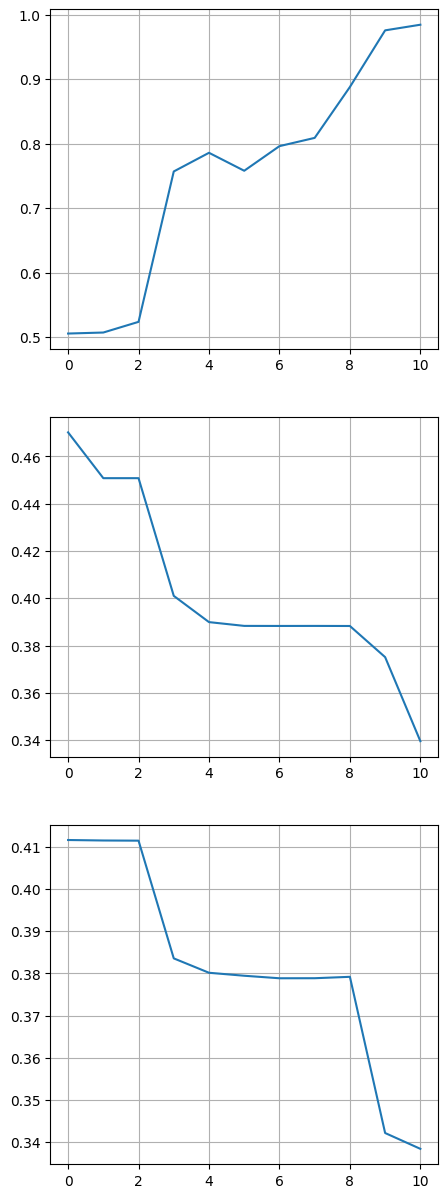

  0%|          | 0/476 [00:00<?, ?it/s]

C:\Users\andre\AppData\Local\Temp\ipykernel_3884\2546190197.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


0.37570399045944214
0.37888070940971375


KeyboardInterrupt: 

In [31]:
for epoch in tqdm.notebook.tqdm(range(EPOCHS)):
    nnet.train()
    batches = batch_generator(train_tokens, y_train, batch_size=BATCH_SIZE)
    for i, batch in tqdm.notebook.tqdm(enumerate(batches), total=len(train_tokens) // BATCH_SIZE):
        pred = nnet(batch[0])
        loss = criterion(pred, batch[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            nnet.eval()
            train_score = criterion(nnet(batch[0]), batch[1])
            print(train_score.item())
            train_scores.append(train_score.item())
    nnet.eval()
    train_scores_mean.append(sum(train_scores) / len(train_scores))
    train_scores = []
    test_pred_prob = nnet(test_tokens_as_matrix)
    test_score = criterion(test_pred_prob, torch.tensor(y_test.values))
    test_auc = roc_auc_score(y_test, test_pred_prob.detach().numpy()[:, 1])
    test_scores.append(test_score.item())
    test_aucs.append(test_auc.item())
    clear_output(True)
    print(f'epoch {epoch}/{EPOCHS}')
    print('auc', test_auc.item())
    print('score', test_score.item())
    plt.figure(figsize=(5, 15))
    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(np.arange(epoch + 1), test_aucs)
    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(np.arange(epoch + 1), train_scores_mean)
    plt.plot(np.arange(epoch + 1), test_scores)
    plt.grid()
    plt.show()

# RNN

In [122]:
def index_tokens(tokens_string):
    return([word_to_idx.get(token, unk_idx) for token in tokens_string])

def fill_with_pads(tokens, pad_idx=0):
    max_len = 0
    for tokens_string in tokens:
        max_len = max(max_len, len(tokens_string))
    for tokens_string in tokens:
        for i in range(len(tokens_string), max_len):
            tokens_string.append(pad_idx)
    return tokens

def as_matrix(tokens):
    tokens = deepcopy(tokens)
    for j, s in enumerate(tokens):
        tokens[j] = index_tokens(s)
    tokens = torch.tensor(fill_with_pads(tokens, pad_idx=pad_idx), dtype=torch.int)
    return tokens

def batch_generator(tokens, labels, batch_size=16):
    for i in range(0, len(tokens), batch_size):
        batch = tokens[i: i + batch_size]
        #eos_indices = [len(seq) - 1 for seq in batch]
        batch_labels = torch.tensor(labels.values[i: i + batch_size], dtype=torch.long)
        yield as_matrix(batch), batch_labels

In [123]:
test_tokens_as_matrix = as_matrix(test_tokens)
test_eos_indices = [len(seq) - 1 for seq in test_tokens]

In [124]:
test_tokens_as_matrix = test_tokens_as_matrix[:500]
test_eos_indices = test_eos_indices[:500]
y_test = y_test[:500]

C:\Users\andre\AppData\Local\Temp\ipykernel_3884\2094621328.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test = y_test[:500]


In [125]:
class RecNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(data_dicts.amount_of_words, 300)
        self.emb.load_state_dict({'weight': torch.tensor(vectors)})
        self.emb.weight.requires_grad=False
        self.gru = nn.GRU(300, 300, batch_first=True)
        self.linear = nn.Linear(300, 2)
    def forward(self, batch):
        emb = self.emb(batch)
        states, last_states = self.gru(emb)
        #last_states = states[np.arange(len(batch)), eos_indices]
        out = self.linear(last_states.squeeze())
        #print(emb.size(), last_states.size(), out.size())
        return F.softmax(out)

In [126]:
nnet = RecNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters())

In [127]:
EPOCHS = 100
BATCH_SIZE = 16
train_scores = []
train_scores_mean = []
test_scores = []
test_aucs = []

epoch 0/100
auc 0.49976058226393405
score 0.40526193380355835


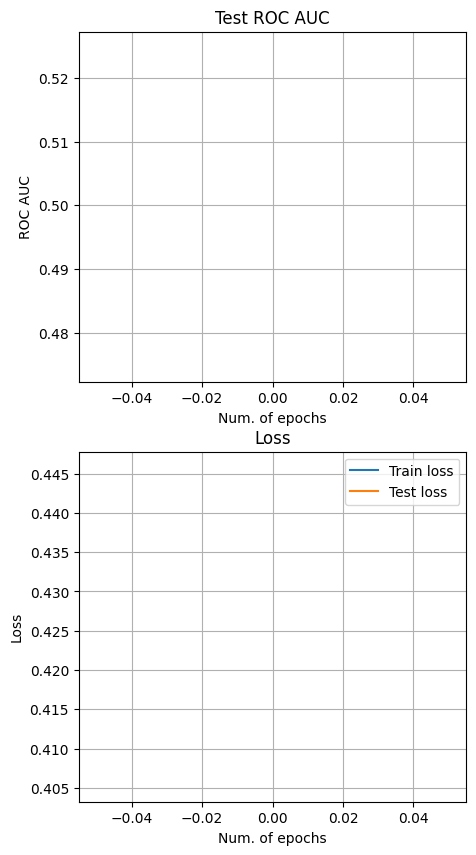

  0%|          | 0/476 [00:00<?, ?it/s]

C:\Users\andre\AppData\Local\Temp\ipykernel_3884\60674017.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


0.43826183676719666
0.5007618069648743
0.3132619559764862


KeyboardInterrupt: 

In [128]:
for epoch in tqdm.notebook.tqdm(range(EPOCHS)):
    nnet.train()
    batches = batch_generator(train_tokens, y_train, batch_size=BATCH_SIZE)
    for i, batch in tqdm.notebook.tqdm(enumerate(batches), total=len(train_tokens) // BATCH_SIZE):
        pred = nnet(batch[0])
        loss = criterion(pred, batch[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            nnet.eval()
            train_score = criterion(nnet(batch[0]), batch[1])
            print(train_score.item())
            train_scores.append(train_score.item())
    nnet.eval()
    train_scores_mean.append(sum(train_scores) / len(train_scores))
    train_scores = []
    test_pred_prob = nnet(test_tokens_as_matrix)
    test_score = criterion(test_pred_prob, torch.tensor(y_test.values))
    test_auc = roc_auc_score(y_test, test_pred_prob.detach().numpy()[:, 1])
    test_scores.append(test_score.item())
    test_aucs.append(test_auc.item())
    clear_output(True)
    print(f'epoch {epoch}/{EPOCHS}')
    print('auc', test_auc.item())
    print('score', test_score.item())
    plt.figure(figsize=(5, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(epoch + 1), test_aucs)
    plt.grid()
    plt.title('Test ROC AUC')
    plt.xlabel('Num. of epochs')
    plt.ylabel('ROC AUC')
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(epoch + 1), train_scores_mean, label='Train loss')
    plt.plot(np.arange(epoch + 1), test_scores, label='Test loss')
    plt.title('Loss')
    plt.xlabel('Num. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()